In [1]:
# load data
import numpy as np
import matplotlib.pyplot as plt
# import skfuzzy as fuzz
from sklearn.cluster import KMeans
from L63_noisy import intL63_noisy, intL63_noisy_fix
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa import stattools 
from scipy.stats import gaussian_kde
import joblib
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import h5py
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
# from FKNN import FuzzyKNN, calculate_distances
from sklearn.metrics import silhouette_score

# from sklearn.metrics import silhouette_score


# fix the random seed
np.random.seed(2022)

# set experiment parameters
dt = 0.03  # model integration time step, dtda should be divisible to dt
N = int(1e6)  # integration time steps
truth = np.load('../../data/naturerun_PWell.npy')
truth.shape

# # write data to hdf5 file 
# hf = h5py.File('../../data/naturerun_PWell.hdf5', 'w')
# hf.create_dataset('x', data=truth.T)
# hf.create_dataset('dt', data=dt)
# hf.close()

(3, 1000000)

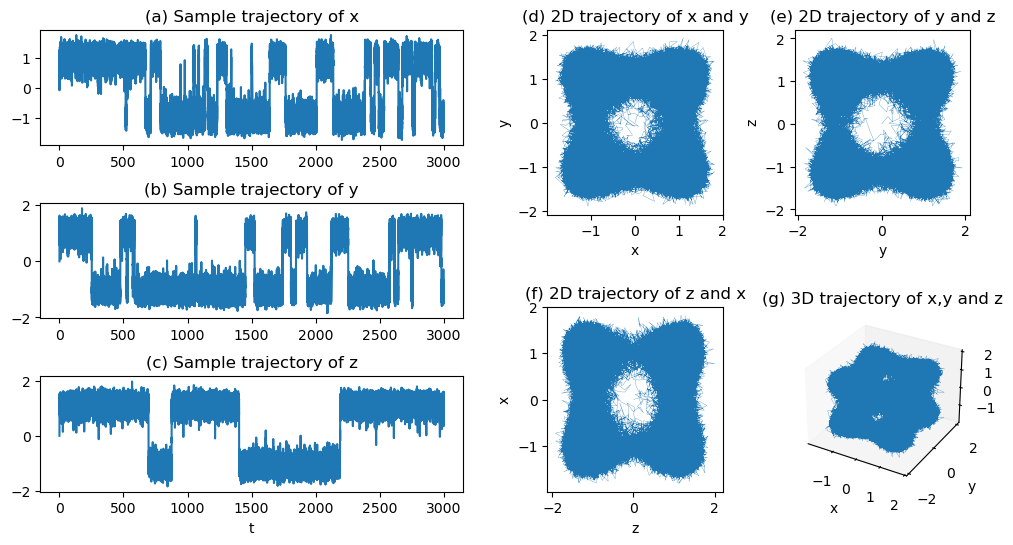

In [93]:
# Plot
x1, y1, z1 = truth

sel0 = 0; sel1 = 100000 # plot time range
interv = 1 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)     # Adjust the overall spacing of the figure
gs0 = GridSpec(1, 2, figure=fig)
gs00 = gs0[0].subgridspec(3, 6)
ax1 = fig.add_subplot(gs00[0, :])
ax2 = fig.add_subplot(gs00[1, :])
ax3 = fig.add_subplot(gs00[2, :])

ax1.plot(xaxis, x1[sel0:sel1:interv])
# ax1.set_xlim(50, 100)
ax1.set_title('(a) Sample trajectory of x')

ax2.plot(xaxis, y1[sel0:sel1:interv])
# ax2.set_xlim(50, 100)
ax2.set_title('(b) Sample trajectory of y')

ax3.plot(xaxis, z1[sel0:sel1:interv])
# ax3.set_xlim(50, 100)
ax3.set_title('(c) Sample trajectory of z')
ax3.set_xlabel('t')

# create a new GridSpec for the second column
gs01 = gs0[1].subgridspec(2, 7)

ax4 = fig.add_subplot(gs01[0, :3])
ax5 = fig.add_subplot(gs01[0, 4:])
ax6 = fig.add_subplot(gs01[1, :3])
ax7 = fig.add_subplot(gs01[1, 4:], projection='3d')

ax4.plot(x1, y1, lw=0.2)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title('(d) 2D trajectory of x and y')

ax5.plot(y1, z1, lw=0.2)
ax5.set_xlabel('y')
ax5.set_ylabel('z')
ax5.set_title('(e) 2D trajectory of y and z')

ax6.plot(z1, x1, lw=0.2)
ax6.set_xlabel('z')
ax6.set_ylabel('x')
ax6.set_title('(f) 2D trajectory of z and x')

ax7.plot(x1, y1, z1, lw=0.2)
ax7.set_xlabel("x")
ax7.set_ylabel("y")
ax7.set_zlabel("z")
ax7.set_title('(g) 3D trajectory of x,y and z')
ax7.grid(False)

plt.savefig('../../fig/Truth_traj_PWell.png', dpi=150)
plt.show()

# 1. Classification

## 1.1 autocorrelation

x Decorrelation Time: 23.58 time units
y Decorrelation Time: 57.54 time units
z Decorrelation Time: 137.43 time units


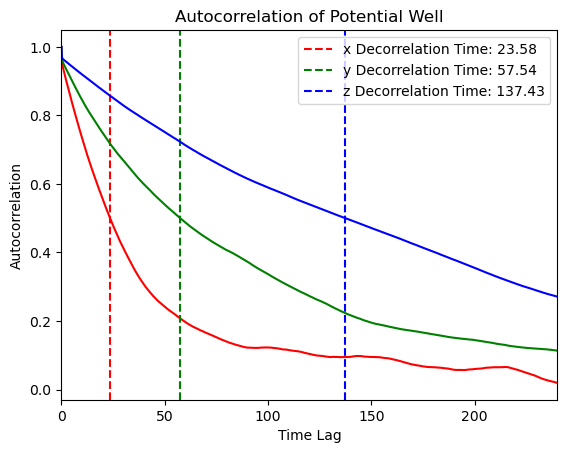

In [21]:
# compute autocorrelation
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa import stattools 


autocorr_x = stattools.acf(truth[0,:],nlags=8000)  # Autocorrelation of x component
autocorr_y = stattools.acf(truth[1,:],nlags=8000)  # Autocorrelation of y component
autocorr_z = stattools.acf(truth[2,:],nlags=8000)  # Autocorrelation of z component

# Find decorrelation time (time lag at which autocorrelation drops to a certain threshold)
threshold = 0.5
decorrelation_time_index = np.argmax(autocorr_x < threshold)
decorrelation_time_x = decorrelation_time_index * dt
decorrelation_time_index = np.argmax(autocorr_y < threshold)
decorrelation_time_y = decorrelation_time_index * dt
decorrelation_time_index = np.argmax(autocorr_z < threshold)
decorrelation_time_z = decorrelation_time_index * dt

tmax = dt*autocorr_x.shape[0]
t = np.arange(0.0, tmax, dt)
# Plot autocorrelation function and decorrelation time
plt.plot(t, autocorr_x, color='r')
plt.axvline(x=decorrelation_time_x, color='r', linestyle='--', label=f'x Decorrelation Time: {decorrelation_time_x:.2f}')
plt.plot(t, autocorr_y, color='g')
plt.axvline(x=decorrelation_time_y, color='g', linestyle='--', label=f'y Decorrelation Time: {decorrelation_time_y:.2f}')
plt.plot(t, autocorr_z, color='b')
plt.axvline(x=decorrelation_time_z, color='b', linestyle='--', label=f'z Decorrelation Time: {decorrelation_time_z:.2f}')
plt.xlabel('Time Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Potential Well')
plt.legend()
plt.xlim(0, tmax)
# plt.show()
plt.savefig('../../fig/autocorr_PWell.png', dpi=150)

print(f"x Decorrelation Time: {decorrelation_time_x:.2f} time units")
print(f"y Decorrelation Time: {decorrelation_time_y:.2f} time units")
print(f"z Decorrelation Time: {decorrelation_time_z:.2f} time units")



## 1.2 Clustering

### 1.2.1 K-means

/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

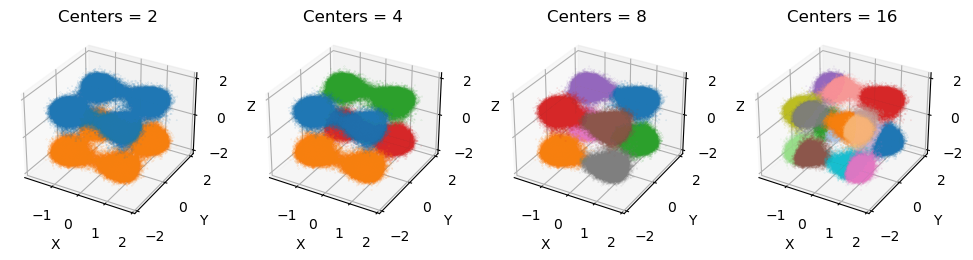

In [2]:
# Kmeans
# Define a custom function to evaluate the predictions with multiple metrics
def evaluate_predictions(truth_label, predicted_label):
    accuracy = accuracy_score(truth_label, predicted_label)
    precision = precision_score(truth_label, predicted_label, average='macro')
    recall = recall_score(truth_label, predicted_label, average='macro')
    return accuracy, precision, recall,

# load labeled time series data
sol = truth
X = sol.T   # X should be a 2D array with shape (n_samples, n_features)

# -------------------------------------------------
# K-means clustering
# Create feature matrix (x, y, z) for clustering
data_matrix = X
x_data = data_matrix[:, 0]
y_data = data_matrix[:, 1]
z_data = data_matrix[:, 2]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']

ncenterss = [2,4,8,16]

# Set up the loop and plot
fig1, axes1 = plt.subplots(1, 4, figsize=(12, 3), subplot_kw=dict(projection='3d'))

for ncenters, ax in zip(ncenterss, axes1):
    kmeans = KMeans(n_clusters=ncenters)#, n_init='auto')
    kmeans.fit(data_matrix)
    labels = kmeans.labels_

    # save data
    dic = {'label':labels, 'centers':kmeans.cluster_centers_}
    np.save('../../data/Kmeans_{0:d}center_Pwell.npy'.format(ncenters), dic)
    joblib.dump(kmeans, "../../data/kmeans_model_{0:d}center_PWell.joblib".format(ncenters))

#     # The silhouette_score gives the average value for all the samples.
#     sil_avg = silhouette_score(data_matrix, labels)

    # Plot assigned clusters, for each data point in training set
    for j in range(ncenters):
        ax.scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
                   label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

#     ax.set_title('Centers = {0}; Avg Sil = {1:.2f}'.format(ncenters, sil_avg))
    ax.set_title('Centers = {0}'.format(ncenters))

plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.savefig('../../fig/Kmeans_PWell.png',dpi=150)
plt.show()

In [31]:
# save labeled data
np.save('Kmeans_label_{0:d}center_Pwell.npy'.format(ncenters), labels)

# 2. Surrogate Model

## 2.1 True signals

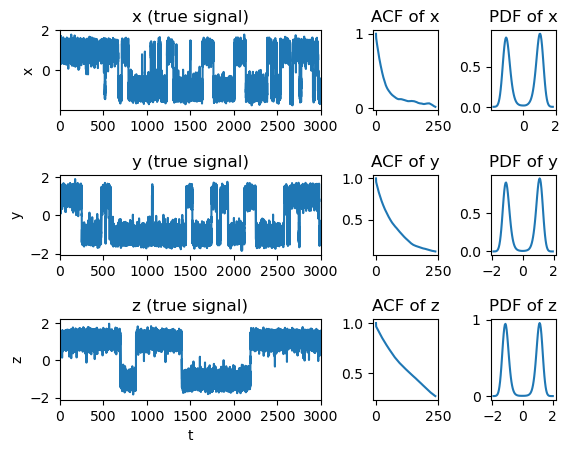

In [62]:
# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

Lag = 8000

fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, (N) * dt, dt), x_truth)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, (N) * dt, dt), y_truth)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, (N) * dt, dt), z_truth)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_truth
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x_truth, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y_truth, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z_truth, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth)
xx = np.linspace(np.min(x_truth), np.max(x_truth), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth)
xx = np.linspace(np.min(y_truth), np.max(y_truth), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth)
xx = np.linspace(np.min(z_truth), np.max(z_truth), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/truesign_PWell.png', dpi=150)
plt.show()

(1000000,)


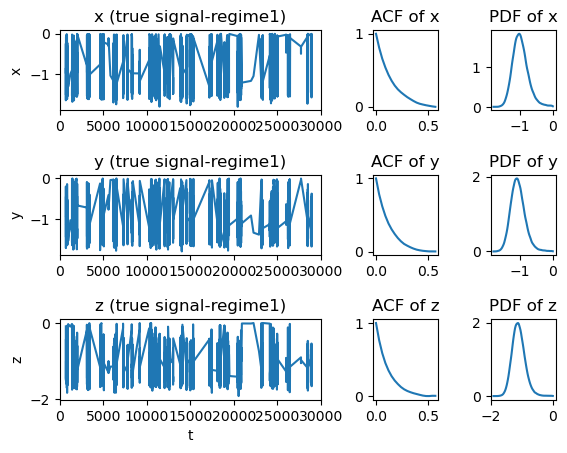

In [78]:
# truth regime1
# load label data
label = np.load('Kmeans_label_8center_Pwell.npy')
print(label.shape)

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Partition data into 2 regimes
bool_label = label == 0
x_truth1 = x_truth[bool_label]
y_truth1 = y_truth[bool_label]
z_truth1 = z_truth[bool_label]
indt1 = np.where(bool_label)[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, x_truth1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal-regime1)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, y_truth1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal-regime1)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, z_truth1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# # Remove last point from candidates
# indt1 = indt1[:-1]

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

Lag = 20

# Subplot for ACF of x_truth
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(x_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(y_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(z_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth1)
xx = np.linspace(np.min(x_truth1), np.max(x_truth1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth1)
xx = np.linspace(np.min(y_truth1), np.max(y_truth1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth1)
xx = np.linspace(np.min(z_truth1), np.max(z_truth1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/truesign_regm1_PWell.png', dpi=150)
plt.show()

(1000000,)


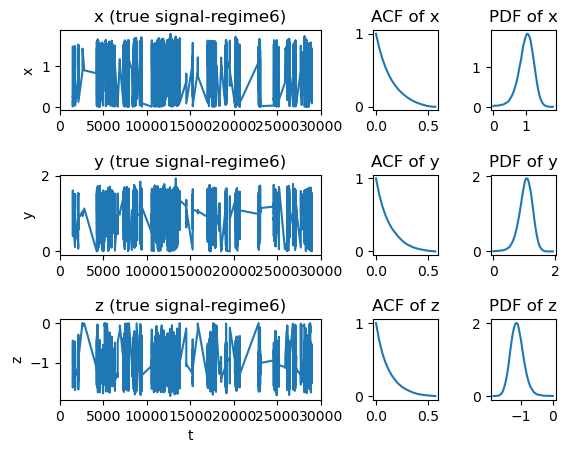

In [34]:
# truth regime6
# load label data
label = np.load('Kmeans_label_8center_Pwell.npy')
print(label.shape)

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = np.vstack((const, x_truth, y_truth, z_truth, x_truth**2, y_truth**2, z_truth**2, x_truth**3, y_truth**3, z_truth**3))

# Partition data into 2 regimes
bool_label = label == 5
x_truth1 = x_truth[bool_label]
y_truth1 = y_truth[bool_label]
z_truth1 = z_truth[bool_label]
All_Candidates1 = All_Candidates[:,bool_label]
indt1 = np.where(label==5)[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, x_truth1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal-regime6)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, y_truth1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal-regime6)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, z_truth1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal-regime6)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Remove last point from candidates
All_Candidates1 = All_Candidates1[:, :-1]
indt1 = indt1[:-1]

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

Lag = 20

# Subplot for ACF of x_truth
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(x_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(y_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(z_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth1)
xx = np.linspace(np.min(x_truth1), np.max(x_truth1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth1)
xx = np.linspace(np.min(y_truth1), np.max(y_truth1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth1)
xx = np.linspace(np.min(z_truth1), np.max(z_truth1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/truesign_regm6_PWell.png', dpi=150)
plt.show()

## 2.2 Surrogate Model of the Complete System

In [55]:
# Model Identification
from scipy.linalg import det

# load label data
label = np.load('Kmeans_label_8center_Pwell.npy')

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**2, x_truth**3, y_truth**3, z_truth**3))

# Parameters
threshold = 0.0005 # threshold of causation entropy
L = All_Candidates.shape[0]

# Partition data into 8 regimes
ncenters = 8
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []
derivs = []

deriv = np.load('derivative_PWell.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    All_Candi_list.append(All_Candidates[:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('x, y, z, xy, yz, zx, x^2, y^2, z^2, x^3, y^3, z^3')

# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
CEM = np.zeros((3, L))
for k in range(3):
    All_Variables1 = np.vstack((All_Candidates, deriv[k,:]))
    All_Cov = np.cov(All_Variables1)

    for i in range(L):
        RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
        RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
        RXYZ = All_Cov
        RYZ = All_Cov[:L, :L]

        CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

CEM_Original1 = CEM
CEM_indicator1 = (CEM_Original1 > threshold).astype(int)

print('Regime{:d}'.format(0))
print('Model structure (identified model):')
print(CEM_indicator1)
print('CEM_Original',CEM_Original1)

Candidate functions:
x, y, z, xy, yz, zx, x^2, y^2, z^2, x^3, y^3, z^3
Regime0
Model structure (identified model):
[[1 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 1]]
CEM_Original [[4.04558143e-02 3.76786193e-08 1.96771099e-07 1.19417473e-06
  2.47313832e-08 1.56096386e-07 5.74037653e-07 1.12141070e-08
  6.36664347e-07 5.22314005e-02 7.16692865e-08 1.91999918e-07]
 [3.76271121e-08 4.68455748e-02 4.32563798e-08 1.31583059e-06
  2.67139828e-07 5.20025128e-07 1.40235287e-06 5.78029812e-07
  5.29418038e-08 9.69014495e-08 5.83912394e-02 1.16413160e-07]
 [3.37290803e-07 9.74114164e-07 5.40222183e-02 1.41114587e-08
  2.59805834e-06 6.54136525e-07 7.11610891e-07 2.53341923e-07
  2.51976718e-07 4.76120604e-07 1.17756681e-06 6.53448629e-02]]


Candidate functions:
x, y, z, x^3, y^3, z^3
Model structure (truth):
[[1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 1]]
Model structure (Physics constrained surrogate model):
[[1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 1]]
Theta1_Constraint
 [ 3.8005088  -3.38528206  4.11503396 -3.3354709   4.52156428 -3.36232233]
sigma1
 [[ 0.79278089  0.         -0.        ]
 [ 0.          0.79626119  0.        ]
 [-0.          0.          0.80416696]]


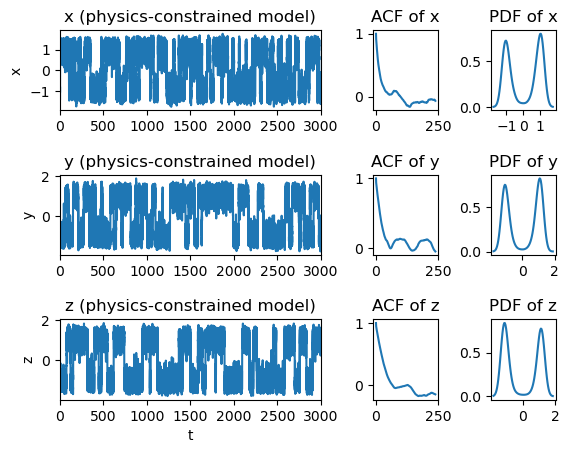

In [16]:
# Surrogate Model of the Complete System
# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth**3, y_truth**3, z_truth**3))

# Surrogate model with Physics Constraints
True_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                 [0, 1, 0, 0, 1, 0],
                                 [0, 0, 1, 0, 0, 1]], dtype=int)
Surro_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                  [0, 1, 0, 0, 1, 0],
                                  [0, 0, 1, 0, 0, 1]], dtype=int)
print('Candidate functions:')
print('x, y, z, x^3, y^3, z^3')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (Physics constrained surrogate model):')
print(Surro_Model_Structure)

# Parameter estimation of the surrogate model
num_theta = 6
num_constraints = 2
H = np.zeros((num_constraints, num_theta))
H[0, 4] = 1
g = np.zeros((num_constraints,1))

Theta = np.zeros(num_theta)
Sigma = np.zeros((3, 3))
All_Candidates1 = All_Candidates
x_truth1 = x_truth
y_truth1 = y_truth
z_truth1 = z_truth

for _ in range(10):
    count = 0
    for i in range(N - 1):
        M = np.zeros((3, num_theta))

        M[0, 0] = All_Candidates1[0, i]
        M[0, 1] = All_Candidates1[3, i]
        M[1, 2] = All_Candidates1[1, i]
        M[1, 3] = All_Candidates1[4, i]
        M[2, 4] = All_Candidates1[2, i]
        M[2, 5] = All_Candidates1[5, i]

        M = M * dt
        z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
        s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
        Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
        count += 1

    Sigma = Sigma / count * np.eye(3)
    invSigma = np.linalg.inv(Sigma)
    D = np.zeros((num_theta, num_theta))
    c = np.zeros((num_theta,1))

    for i in range(N - 1):
        M = np.zeros((3, num_theta))

        M[0, 0] = All_Candidates1[0, i]
        M[0, 1] = All_Candidates1[3, i]
        M[1, 2] = All_Candidates1[1, i]
        M[1, 3] = All_Candidates1[4, i]
        M[2, 4] = All_Candidates1[2, i]
        M[2, 5] = All_Candidates1[5, i]

        M = M * dt
        z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
        s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
        D += M.T @ invSigma @ M
        c += M.T @ invSigma @ (z - s)

    D = D / count
    c = c / count
    Theta1 = np.linalg.solve(D, c)
    Theta1_Constraint = Theta1[:,0]

Sigma1 = Sigma
print('Theta1_Constraint\n',Theta1_Constraint)
print('sigma1\n',(Sigma1/dt)**0.5)


N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

for i in range(1, N):
    der_x[i-1] = (Theta1_Constraint[0] * x1[i - 1] + Theta1_Constraint[1] * x1[i - 1]**3) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta1_Constraint[2] * y1[i - 1] + Theta1_Constraint[3] * y1[i - 1]**3) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta1_Constraint[4] * z1[i - 1] + Theta1_Constraint[5] * z1[i - 1]**3) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
   
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])


# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (physics-constrained model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (physics-constrained model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (physics-constrained model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag = 8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/CompletePerfectModel_PWell.png', dpi=150)
plt.show()


## 2.3 Surrogate Model of the Regimes

In [54]:
# Model Identification
from scipy.linalg import det

# load label data
label = np.load('Kmeans_label_8center_Pwell.npy')

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**2, x_truth**3, y_truth**3, z_truth**3))

# Parameters
threshold = 0.0001 # threshold of causation entropy
L = All_Candidates.shape[0]

# Partition data into 8 regimes
ncenters = 8
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []
derivs = []

deriv = np.load('derivative_PWell.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    All_Candi_list.append(All_Candidates[:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('x, y, z, xy, yz, zx, x^2, y^2, z^2, x^3, y^3, z^3')

# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    CEM_indicator1 = (CEM_Original1 > threshold).astype(int)

    print('Regime{:d}'.format(rgm))
    print('Model structure (identified model):')
    print(CEM_indicator1)
    print('CEM_Original',CEM_Original1)

Candidate functions:
x, y, z, xy, yz, zx, x^2, y^2, z^2, x^3, y^3, z^3
Regime0
Model structure (identified model):
[[1 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0]]
CEM_Original [[4.18313635e-04 5.43790435e-06 8.29655096e-06 1.42302174e-07
  5.78964361e-06 2.30879253e-05 1.86914900e-04 6.87235847e-07
  1.10503580e-06 2.57999998e-05 1.49486254e-08 6.48173881e-07]
 [6.07431513e-06 2.43914934e-04 2.02137092e-06 1.82608211e-06
  1.37402905e-05 8.27007327e-06 3.82263380e-06 1.78671634e-04
  1.83659130e-06 2.90111216e-06 1.09992657e-05 7.89893061e-07]
 [3.77208124e-06 7.11545169e-08 3.18665895e-04 1.13708136e-05
  6.43151801e-06 1.55314347e-06 1.55321931e-06 2.55295163e-09
  1.68405414e-04 1.51926486e-06 2.44824960e-09 9.43629580e-06]]
Regime1
Model structure (identified model):
[[1 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0]]
CEM_Original [[3.88042076e-04 2.27829518e-05 5.83485920e-06 1.29958542e-05
  4.91737808e-07 3.17468673

Candidate functions:
x, y, z, x^2, y^2, z^2
Model structure (Physics constrained surrogate model):
[[1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 1]]
regime:  0
Theta1_Constraint
 [7.49705219 7.18657403 8.36933566 7.62017738 8.90703515 7.75293006]
sigma1
 [[ 0.79177317  0.          0.        ]
 [ 0.          0.79608101 -0.        ]
 [ 0.         -0.          0.80245872]]
regime:  1
Theta1_Constraint
 [ 7.47742621 -7.16180913  8.14349563 -7.43780789  8.74704782 -7.63727493]
sigma1
 [[ 0.7927713   0.          0.        ]
 [ 0.          0.79633003 -0.        ]
 [ 0.         -0.          0.80336441]]
regime:  2
Theta1_Constraint
 [ 7.52275189  7.19652769  8.09726011 -7.40005134  8.96944996  7.83283314]
sigma1
 [[ 0.79002453 -0.          0.        ]
 [-0.          0.79432007 -0.        ]
 [ 0.         -0.          0.80578819]]
regime:  3
Theta1_Constraint
 [ 7.59619419  7.26141585  8.08381005 -7.38877219  8.97019901 -7.83731325]
sigma1
 [[ 0.79371241 -0.         -0.        ]
 [-0.          0.796

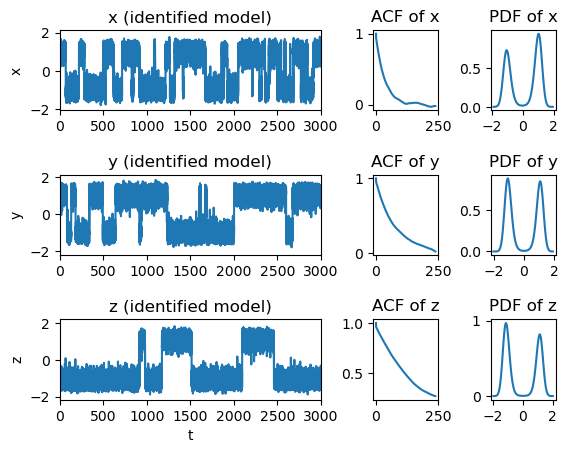

In [71]:
# surrogate model of regimes
# load label data
label = np.load('Kmeans_label_8center_Pwell.npy')

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth**2, y_truth**2, z_truth**2))

# Partition data into 8 regimes
ncenters = 8
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    All_Candi_list.append(All_Candidates[:,bool_label][:, :-1])   # Remove last point from candidates
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

# Surrogate model with Physics Constraints
True_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                 [0, 1, 0, 0, 1, 0],
                                 [0, 0, 1, 0, 0, 1]], dtype=int)
Surro_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                  [0, 1, 0, 0, 1, 0],
                                  [0, 0, 1, 0, 0, 1]], dtype=int)

print('Candidate functions:')
print('x, y, z, x^2, y^2, z^2')
# print('Model structure (truth):')
# print(True_Model_Structure)
print('Model structure (Physics constrained surrogate model):')
print(Surro_Model_Structure)

# Parameter estimation of the surrogate model
num_theta = 6
num_constraints = 2
H = np.zeros((num_constraints, num_theta))
H[0, 4] = 1
g = np.zeros((num_constraints,1))
Theta_Constraints = []
Sigmas = []

for nc in range(ncenters):
    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))

                M[0, 0] = All_Candidates1[0, i]
                M[0, 1] = All_Candidates1[3, i]
                M[1, 2] = All_Candidates1[1, i]
                M[1, 3] = All_Candidates1[4, i]
                M[2, 4] = All_Candidates1[2, i]
                M[2, 5] = All_Candidates1[5, i]
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                
                M[0, 0] = All_Candidates1[0, i]
                M[0, 1] = All_Candidates1[3, i]
                M[1, 2] = All_Candidates1[1, i]
                M[1, 3] = All_Candidates1[4, i]
                M[2, 4] = All_Candidates1[2, i]
                M[2, 5] = All_Candidates1[5, i]
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
#         lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
#         Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        Theta1_Constraint = Theta1
    
    Sigmas.append(Sigma)
    Theta_Constraints.append(np.squeeze(Theta1_Constraint))

    Sigma1 = Sigma
    print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
#     print('Sigma1\n',Sigma1)
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

classify_model = joblib.load("kmeans_model_PWell.joblib")
pred_label = np.zeros(N)

for i in range(1, N):
    rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    pred_label[i-1]  =rgm
    der_x[i-1] = (Theta_Constraints[rgm][0] * x1[i - 1] + Theta_Constraints[rgm][1] * x1[i - 1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta_Constraints[rgm][2] * y1[i - 1] + Theta_Constraints[rgm][3] * y1[i - 1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta_Constraints[rgm][4] * z1[i - 1] + Theta_Constraints[rgm][5] * z1[i - 1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
   
pred_label[N-1] = classify_model.predict(np.array([x1[N-1],y1[N-1],z1[N-1]])[None,:])[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_PWell.png', dpi=150)
plt.show()

In [ ]:
# the computational cost of regimes clasification may be more expensive than the integration

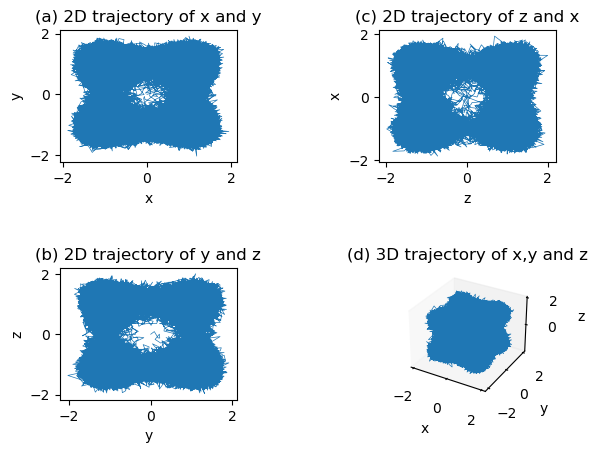

In [72]:
# plot
fig = plt.figure()
widths = [3, 3]
heights = [16, 16]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.8, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[0, 1])
ax4 = fig.add_subplot(spec[1, 1], projection='3d')

# Subplot for x_1
ax1.plot(x1, y1, lw=0.5)
ax1.set_title('(a) 2D trajectory of x and y')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.plot(y1, z1, lw=0.5)
ax2.set_title('(b) 2D trajectory of y and z')
ax2.set_xlabel('y')
ax2.set_ylabel('z')

ax3.plot(z1, x1, lw=0.5)
ax3.set_title('(c) 2D trajectory of z and x')
ax3.set_xlabel('z')
ax3.set_ylabel('x')

ax4.plot(x1, y1, z1, lw=0.5)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("z")
ax4.set_title('(d) 3D trajectory of x,y and z')
ax4.grid(False)
    
# plt.savefig('../../fig/Regime1PhysConstrModel_2dtraj.png', dpi=150)
plt.show()

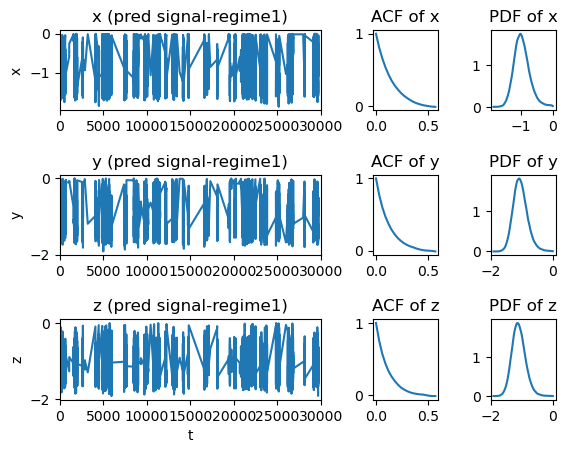

In [74]:
# plot regime1 CEM
boolpredlab = pred_label==0
xpred1 = x1[boolpredlab]
ypred1 = y1[boolpredlab]
zpred1 = z1[boolpredlab]
indt1 = np.where(boolpredlab)[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for xpred
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, xpred1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (pred signal-regime1)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, ypred1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (pred signal-regime1)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, zpred1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (pred signal-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

Lag = 20

# Subplot for ACF of xpred
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(xpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(ypred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(zpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of xpred
kde = gaussian_kde(xpred1)
xx = np.linspace(np.min(xpred1), np.max(xpred1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(ypred1)
xx = np.linspace(np.min(ypred1), np.max(ypred1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(zpred1)
xx = np.linspace(np.min(zpred1), np.max(zpred1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/pred_regm1_CEM_PWell.png', dpi=150)
plt.show()

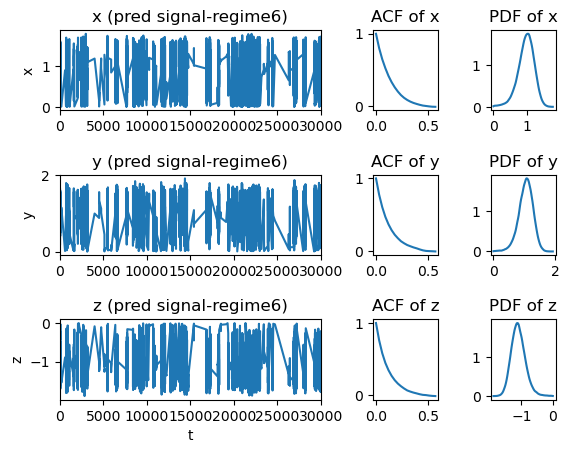

In [75]:
# plot regime6 CEM
boolpredlab = pred_label==5
xpred1 = x1[boolpredlab]
ypred1 = y1[boolpredlab]
zpred1 = z1[boolpredlab]
indt1 = np.where(boolpredlab)[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for xpred
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, xpred1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (pred signal-regime6)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, ypred1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (pred signal-regime6)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, zpred1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (pred signal-regime6)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

Lag = 20

# Subplot for ACF of xpred
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(xpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(ypred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(zpred1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of xpred
kde = gaussian_kde(xpred1)
xx = np.linspace(np.min(xpred1), np.max(xpred1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(ypred1)
xx = np.linspace(np.min(ypred1), np.max(ypred1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(zpred1)
xx = np.linspace(np.min(zpred1), np.max(zpred1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/pred_regm6_CEM_PWell.png', dpi=150)
plt.show()

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_30329/3025852044.py:11: RuntimeWarning: overflow encountered in scalar power
  der_x[i-1] = (Theta_Constraints[rgm][0] * x1[i - 1] + Theta_Constraints[rgm][1] * x1[i - 1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_30329/3025852044.py:12: RuntimeWarning: overflow encountered in scalar power
  der_y[i-1] = (Theta_Constraints[rgm][2] * y1[i - 1] + Theta_Constraints[rgm][3] * y1[i - 1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_30329/3025852044.py:13: RuntimeWarning: overflow encountered in scalar power
  der_z[i-1] = (Theta_Constraints[rgm][4] * z1[i - 1] + Theta_Constraints[rgm][5] * z1[i - 1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:470: R

ValueError: array must not contain infs or NaNs

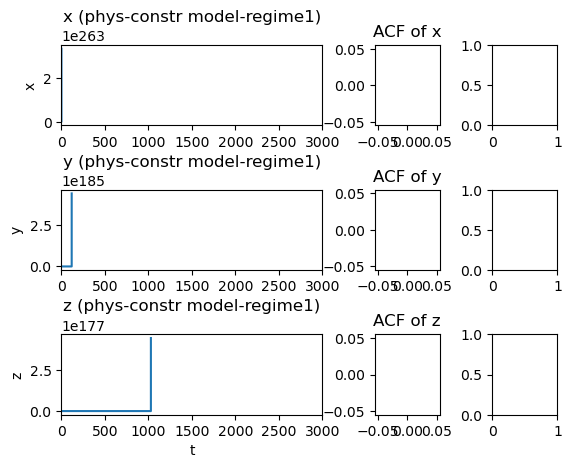

In [69]:
# independent run regime1 model
x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

rgm = 0
for i in range(1, N):
    der_x[i-1] = (Theta_Constraints[rgm][0] * x1[i - 1] + Theta_Constraints[rgm][1] * x1[i - 1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta_Constraints[rgm][2] * y1[i - 1] + Theta_Constraints[rgm][3] * y1[i - 1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta_Constraints[rgm][4] * z1[i - 1] + Theta_Constraints[rgm][5] * z1[i - 1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
    
# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (phys-constr model-regime1)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (phys-constr model-regime1)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (phys-constr model-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/Regime1CEM_PWell.png', dpi=150)
plt.show()

In [94]:
4*1.05**2

4.41

In [95]:
4*1.1**2

4.840000000000001

In [96]:
4*1.15**2

5.289999999999999

Candidate functions:
x, y, z, x^2, y^2, z^2
Model structure (Physics constrained surrogate model):
[[1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 1]]
regime:  0
Theta1_Constraint
 [ 7.49705219e+00  7.18657403e+00 -2.73656176e-01 -6.19774128e-16
 -2.53359890e-01  1.80274712e-16]
sigma1
 [[ 0.79177317  0.          0.        ]
 [ 0.          0.79608101 -0.        ]
 [ 0.         -0.          0.80245872]]
regime:  1
Theta1_Constraint
 [ 7.47742621e+00 -7.16180913e+00 -2.77518287e-01 -6.40152810e-17
 -2.53913736e-01  1.07282864e-15]
sigma1
 [[ 0.7927713   0.          0.        ]
 [ 0.          0.79633003 -0.        ]
 [ 0.         -0.          0.80336441]]
regime:  2
Theta1_Constraint
 [ 7.52275189e+00  7.19652769e+00 -2.76049361e-01 -7.97081989e-16
 -2.55844067e-01 -7.16318147e-16]
sigma1
 [[ 0.79002453 -0.          0.        ]
 [-0.          0.79432007 -0.        ]
 [ 0.         -0.          0.80578819]]
regime:  3
Theta1_Constraint
 [ 7.59619419e+00  7.26141585e+00 -2.76066025e-01 -3.82923638

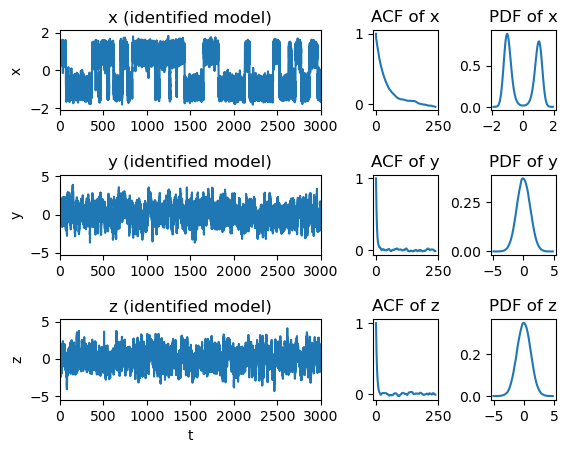

In [101]:
# CG surrogate model of regimes
# load label data
label = np.load('Kmeans_label_8center_Pwell.npy')

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth**2, y_truth**2, z_truth**2))

# Partition data into 8 regimes
ncenters = 8
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    All_Candi_list.append(All_Candidates[:,bool_label][:, :-1])   # Remove last point from candidates
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

# Surrogate model with Physics Constraints
True_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                 [0, 1, 0, 0, 1, 0],
                                 [0, 0, 1, 0, 0, 1]], dtype=int)
Surro_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                  [0, 1, 0, 0, 1, 0],
                                  [0, 0, 1, 0, 0, 1]], dtype=int)

print('Candidate functions:')
print('x, y, z, x^2, y^2, z^2')
# print('Model structure (truth):')
# print(True_Model_Structure)
print('Model structure (Physics constrained surrogate model):')
print(Surro_Model_Structure)

# Parameter estimation of the surrogate model
num_theta = 6
num_constraints = 2
H = np.zeros((num_constraints, num_theta))
H[0, 3] = 1
H[1, 5] = 1
g = np.zeros((num_constraints,1))
Theta_Constraints = []
Sigmas = []

for nc in range(ncenters):
    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))

                M[0, 0] = All_Candidates1[0, i]
                M[0, 1] = All_Candidates1[3, i]
                M[1, 2] = All_Candidates1[1, i]
                M[1, 3] = All_Candidates1[4, i]
                M[2, 4] = All_Candidates1[2, i]
                M[2, 5] = All_Candidates1[5, i]
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                
                M[0, 0] = All_Candidates1[0, i]
                M[0, 1] = All_Candidates1[3, i]
                M[1, 2] = All_Candidates1[1, i]
                M[1, 3] = All_Candidates1[4, i]
                M[2, 4] = All_Candidates1[2, i]
                M[2, 5] = All_Candidates1[5, i]
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
        Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
#         Theta1_Constraint = Theta1
    
    Sigmas.append(Sigma)
    Theta_Constraints.append(np.squeeze(Theta1_Constraint))

    Sigma1 = Sigma
    print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
#     print('Sigma1\n',Sigma1)
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

classify_model = joblib.load("kmeans_model_PWell.joblib")
pred_label = np.zeros(N)

for i in range(1, N):
    rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    pred_label[i-1]  =rgm
    der_x[i-1] = (Theta_Constraints[rgm][0] * x1[i - 1] + Theta_Constraints[rgm][1] * x1[i - 1]**2) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta_Constraints[rgm][2] * y1[i - 1] + Theta_Constraints[rgm][3] * y1[i - 1]**2) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta_Constraints[rgm][4] * z1[i - 1] + Theta_Constraints[rgm][5] * z1[i - 1]**2) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
   
pred_label[N-1] = classify_model.predict(np.array([x1[N-1],y1[N-1],z1[N-1]])[None,:])[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCGCEM_PWell.png', dpi=150)
plt.show()